# How much predictiveness does gene expression add over covariates for Ret? 

Some notes on the results displayed here:
1) Uses Ret as an example
2) Analyzes training/testing auroc for 3 data sets
    -covariates only
    -expression only
    -covariates+expression
3) Feature selection was first performed on the expression data.
4) Using this approach, expression only yields identical training/testing auroc as in Branka's PR #52.
5) Using this approach, the gene expression data does not add much (if anything) to the covariates data in this case.

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

from IPython.core.debugger import Tracer
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 134 ms, sys: 21.1 ms, total: 156 ms
Wall time: 195 ms


In [20]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 16s, sys: 10.4 s, total: 3min 27s
Wall time: 3min 31s


In [4]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 55s, sys: 8.73 s, total: 2min 3s
Wall time: 2min 7s


In [97]:
# Pre-process expression data for use later
def fs_mad(x,y):
    """
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

n_features_select = 500
expression_select = SelectKBest(fs_mad, k=n_features_select).fit_transform(expression,np.ones(expression.shape[0]))
expression_select = pd.DataFrame(expression_select)
expression_select = expression_select.set_index(expression.index.values)

In [206]:
# Create combo data set (processed expression + covariates)
combined = pd.concat([covariates,expression_select],axis=1)
combined.shape

(7306, 570)

In [195]:
mutations = {
    '5979': 'RET',    # ret proto-oncogene
}

In [1]:
# Define model
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'classify__alpha': [10 ** x for x in range(-6, 1)],
    'classify__l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

pipeline = Pipeline(steps=[
    ('impute', Imputer()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced', loss=param_fixed['loss'], 
                               penalty=param_fixed['penalty']))
])

pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

NameError: name 'Pipeline' is not defined

In [213]:
# define helper functions
def train_and_evaluate(data, pipeline):
    """
    Train each model using grid search, and ouput:
    1) all_best_estimator_aurocs: contains aurocs for mean_cv, train, and test for chosen grid parameters
    2) all_grid_aurocs: contains aurocs for each hyperparameter-fold combo in grid search
    """
    all_best_estimator_aurocs = list()
    all_grid_aurocs = pd.DataFrame()
    for m in list(mutations):
        best_estimator_aurocs, grid_aurocs = get_aurocs(data, Y[m], pipeline)
        best_estimator_aurocs['symbol'] = mutations[m]
        grid_aurocs['symbol'] = mutations[m]
        all_grid_aurocs = all_grid_aurocs.append(grid_aurocs, ignore_index = True)
        all_best_estimator_aurocs.append(best_estimator_aurocs) 
    all_best_estimator_aurocs = pd.DataFrame(all_best_estimator_aurocs)
    return all_best_estimator_aurocs, all_grid_aurocs

def get_aurocs(X, y, pipeline):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    grid_aurocs = grid_scores_to_df(pipeline.grid_scores_) 
    best_estimator_aurocs = pd.Series()
    best_estimator_aurocs['mean_cv_auroc'] = grid_aurocs['fold_mean'].max()
    best_estimator_aurocs['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    best_estimator_aurocs['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    best_estimator_aurocs['best_alpha'] = pipeline.best_params_['classify__alpha']
    best_estimator_aurocs['best_11_ratio'] = pipeline.best_params_['classify__l1_ratio']
    best_estimator_aurocs['n_positive_mutation'] = sum(y==1)
    best_estimator_aurocs['n_negative_mutation'] = sum(y==0)
    return best_estimator_aurocs, grid_aurocs

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter and each column a fold.
    """
    rows = []
    for grid_score in grid_scores:
        row = np.concatenate(([grid_score.parameters['classify__alpha']],
                              [grid_score.parameters['classify__l1_ratio']],
                            grid_score.cv_validation_scores))
        rows.append(row)
    grid_aurocs = pd.DataFrame(rows,columns=['alpha', 'l1_ratio','fold_1','fold_2','fold_3'])
    grid_aurocs['fold_mean'] = grid_aurocs.iloc[:,2:4].mean(axis=1)
    grid_aurocs['fold_std'] = grid_aurocs.iloc[:,2:4].std(axis=1)
    return grid_aurocs

def visualize_grid_aurocs(grid_aurocs):
    """
    Visualize grid search results for each mutation-alpha parameter combo.
    """
    grid_aurocs_mat = pd.pivot_table(grid_aurocs, values='fold_mean', index='alpha', columns='l1_ratio')
    ax = sns.heatmap(grid_aurocs_mat, annot=True, fmt='.1%')
    ax.set_xlabel('l1_ratio')
    ax.set_ylabel('Regularization strength multiplier (alpha)');
    
def visualize_best_estimator_aurocs(estimator_aurocs, data_type):
    """
    Creates a bar plot of mean_cv_auroc, training_auroc, and testing_auroc for each gene in df
    """
    plot_df = pd.melt(estimator_aurocs, id_vars='symbol', 
                      value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], 
                      var_name='kind', value_name=data_type)
    grid = sns.factorplot(y='symbol', x=data_type, hue='kind', data=plot_df, kind="bar")

In [2]:
# Train and visualize with covariates data
all_best_estimator_aurocs_covariates, all_grid_aurocs_covariates = train_and_evaluate(covariates, pipeline)
display(all_best_estimator_aurocs_covariates)
visualize_best_estimator_aurocs(all_best_estimator_aurocs_covariates, 'auroc (covariates)'); plt.show()
visualize_grid_aurocs(all_grid_aurocs_covariates); plt.show()

NameError: name 'train_and_evaluate' is not defined

,mean_cv_auroc,training_auroc,testing_auroc,best_alpha,best_11_ratio,n_positive_mutation,n_negative_mutation,symbol
0,0.747791,0.840602,0.766874,1.0,0.0,117.0,7189.0,RET


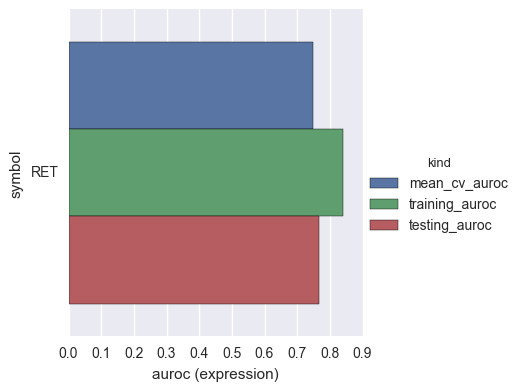

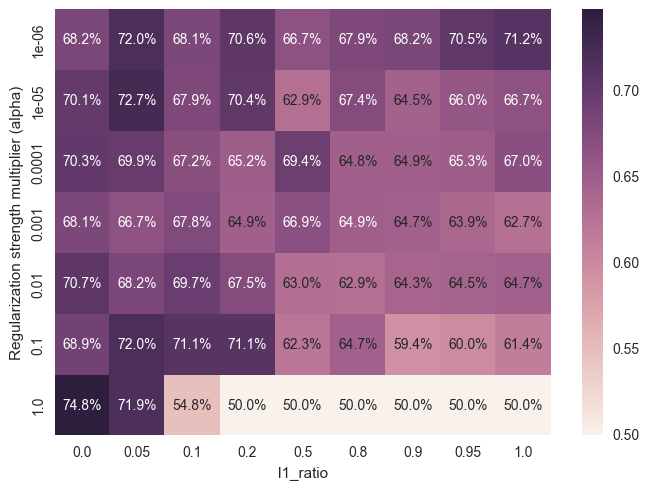

In [215]:
# Train and visualize with expression data
all_best_estimator_aurocs_expression, all_grid_aurocs_expression = train_and_evaluate(expression_select, pipeline)
display(all_best_estimator_aurocs_expression)
visualize_best_estimator_aurocs(all_best_estimator_aurocs_expression, 'auroc (expression)'); plt.show()
visualize_grid_aurocs(all_grid_aurocs_expression); plt.show()

,mean_cv_auroc,training_auroc,testing_auroc,best_alpha,best_11_ratio,n_positive_mutation,n_negative_mutation,symbol
0,0.797742,0.781322,0.884669,1.0,0.1,117.0,7189.0,RET


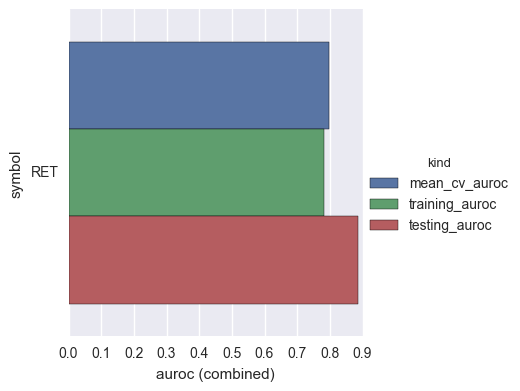

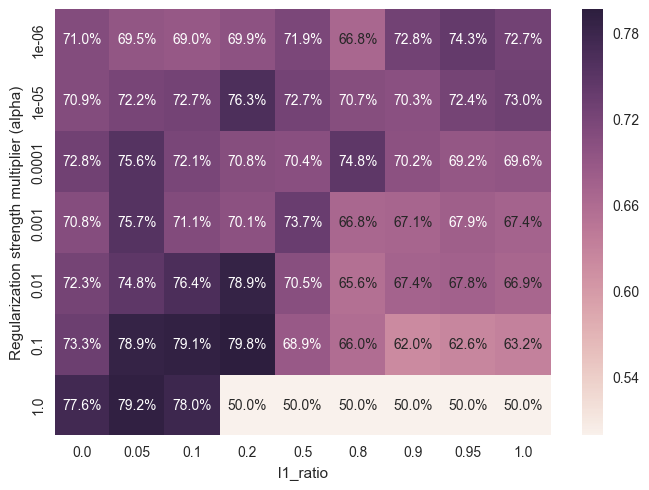

In [216]:
# Train and visualize with combined data
all_best_estimator_aurocs_combined, all_grid_aurocs_combined = train_and_evaluate(combined, pipeline)
display(all_best_estimator_aurocs_combined)
visualize_best_estimator_aurocs(all_best_estimator_aurocs_combined, 'auroc (combined)'); plt.show()
visualize_grid_aurocs(all_grid_aurocs_combined); plt.show()

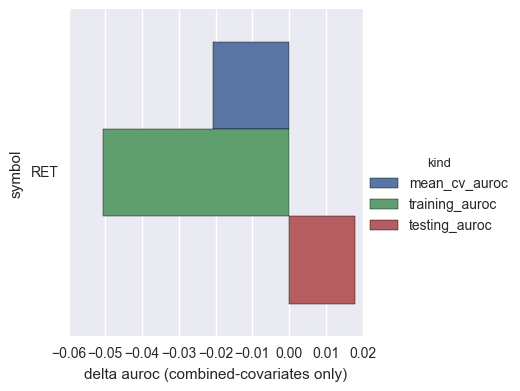

In [218]:
# Display difference in auroc between combined and covariates only 
diff_aurocs = all_best_estimator_aurocs_combined.iloc[:,0:3] - all_best_estimator_aurocs_covariates.iloc[:,0:3]
diff_aurocs['symbol'] = all_best_estimator_aurocs_combined.iloc[:,-1]
visualize_best_estimator_aurocs(diff_aurocs, 'delta auroc (combined-covariates only)')